### Packages

In [ ]:
# cd /project/3022057.01/IFA
# module load anaconda3
# source activate IFAenv
# jupyter notebook --no-browser --ip=* --port=8888 --NotebookApp.token=''

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.signal import sawtooth
from sklearn.decomposition import FastICA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import MDS
from sklearn.covariance import LedoitWolf
from sklearn.linear_model import LogisticRegression, LinearRegression, MultiTaskLasso, Lasso, LassoCV, ElasticNet, MultiTaskLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from nilearn import plotting as nplot
from nilearn import image as nimg
from nilearn import datasets, plotting
from nilearn.regions import connected_label_regions
from nilearn import input_data
from nilearn import image as nimg
from nilearn.connectome import ConnectivityMeasure
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance
from pyriemann.utils.tangentspace import tangent_space, untangent_space, log_map_riemann, unupper
from pyriemann.utils.distance import distance_riemann
from pyriemann.utils.base import logm
import torch

### MELODIC C++ Code

In [ ]:
from scipy.special import loggamma


def Feta(p, n):
    # Compute nu, b_m, and b_p based on the Marchenko-Pastur distribution. Start of first paragraph under equation 9 in MELODIC/PICA 
    # p number of feature, n number of samples
    nu = float(p)/n
    bm = (1-np.sqrt(nu))**2
    bp = (1+np.sqrt(nu))**2

    # Define the lower and upper ranges for eta 
    lrange = 0.9*bm
    urange = 1.1*bp

    # Initialize eta with a 
    eta = np.zeros(30 * p)
    rangestepsize = (urange - lrange) / len(eta)
    for ctr_i in range(len(eta)):
        eta[ctr_i] = lrange + rangestepsize * (ctr_i + 1)

    teta = np.zeros(10 * p)  # Initialize teta with zeros, 10 times the size of p
    stepsize = (bp - bm) / len(teta)  # Step size for teta values
    for ctr_i in range(len(teta)):
        teta[ctr_i] = stepsize * (ctr_i + 1)  # Fill teta with values linearly spaced

    # Calculate feta (pdf of Wishart/Marchenko-Pastuur) using element-wise operations
    feta = (1 / (2 * np.pi * nu * (teta + bm))) * np.sqrt(teta * (bp - bm - teta))

    teta = teta + bm  # Shift teta by bm

    claw = np.zeros_like(eta)  # Initialize Circular Law  with zeros
    tmpval = 0
    ctr_j = 0
    for ctr_i in range(len(eta)):
        while ctr_j < len(teta) and teta[ctr_j] < eta[ctr_i]:
            tmpval += feta[ctr_j]
            ctr_j += 1
        claw[ctr_i] = max(p * (1 - stepsize * tmpval), 0.0)  # Populate claw with cumulative values

    Res = np.zeros(p)  # Initialize Res with zeros
    for ctr_i in range(1, len(eta)):
        if np.floor(claw[ctr_i]) > np.floor(claw[ctr_i - 1]):
            Res[int(np.floor(claw[ctr_i]))] = eta[ctr_i]  # Invert the CDF

    return Res  # Return the result

def adj_eigspec(eigenvalues, n):
    # eigenspectrum assumed to be sorted
    # Calculate CircleLaw using Feta function
    CircleLaw = Feta(len(eigenvalues), n)
    
    # Threshold small values in CircleLaw
    CircleLaw = np.maximum(CircleLaw, 5e-10)
    
    # Adjust eigenvalues by CircleLaw
    AdjEV = eigenvalues * CircleLaw[:len(eigenvalues)]**-1
    
    # Normalize AdjEV to the range [0, 1]
    AdjEV = (AdjEV - np.min(AdjEV)) / (np.max(AdjEV) - np.min(AdjEV))
    
    return AdjEV

def ppca_est_laplace(eigenvalues, N):
    """
    Estimate the dimensionality of the data using Laplace's method.

    Parameters:
    eigenvalues (numpy.ndarray): The eigenvalues of the covariance matrix.
    N (int): The number of data points.

    Returns:
    int: The estimated dimensionality.
    """
    d = len(eigenvalues)
    log_lambda = np.log(eigenvalues)
    
    k = np.arange(1, d + 1)
    m = d * k - 0.5 * k * (k + 1)
    
    loggam = 0.5 * np.flip(k)
    loggam = np.cumsum(loggamma(loggam))
    
    l_probU = -np.log(2) * k + loggam - np.cumsum(0.5 * np.log(np.pi) * np.flip(k))
    
    tmp1 = -np.cumsum(np.flip(eigenvalues)) + np.sum(eigenvalues)
    tmp1 = np.flip(tmp1)
    tmp1[0] = 0.95 * tmp1[1]
    
    tmp2 = -np.cumsum(np.flip(log_lambda)) + np.sum(log_lambda)
    tmp2 = np.flip(tmp2)
    tmp2[0] = tmp2[1]
    
    tmp3 = d - k
    tmp3[-1] = 1.0
    
    tmp4 = tmp1 / tmp3
    tmp4[tmp4 < 0.01] = 0.01
    tmp3[tmp3 < 0.01] = 0.01
    tmp1[tmp1 < 0.01] = 0.01
    
    l_nu = -N / 2 * (d - k) * np.log(tmp4)
    l_nu[-1] = 0
    
    l_lam = -(N / 2) * np.cumsum(log_lambda)
        
    triu = np.triu(np.ones((d, d)), 1)
    t1 = np.outer(np.ones(d), eigenvalues) - np.outer(eigenvalues, np.ones(d))
    t1 = triu * t1.T
    t1[t1 <= 0] = 1
    t1 = np.cumsum(np.sum(np.log(t1), axis=1))
    
    t2 = 1 / tmp4
    t2 = np.outer(t2, np.ones(d)) - np.outer(np.ones(d), 1 / eigenvalues)
    t2 = triu * t2.T
    t2[t2 <= 0] = 1
    t2 = np.cumsum(np.sum(np.log(t2), axis=1))
    
    l_Az = t1 + t2
    
    l_lap = l_probU + l_nu + l_Az + l_lam + 0.5 * np.log(2 * np.pi) * (m + k) - 0.5 * np.log(N) * k
    
    estimated_dim = np.argmax(l_lap) + 1
    return estimated_dim

def run_pca_and_estimate_components(X):
    # Run PCA
    n_samples, n_features = X.shape
    X_meaned = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_meaned, rowvar=False)
    eigenvalues, eigenvectors = eigh(cov_matrix)
    eigenvalues = np.flip(eigenvalues)
    eigenvectors = np.flip(eigenvectors, axis=1)

    # Adjust eigenvalues
    adjusted_eigenvalues = adj_eigspec(eigenvalues, n_samples)

    # Estimate number of components using Laplace method
    estimated_components, laplace_scores = ppca_est_laplace(adjusted_eigenvalues, n_samples)

    # Create scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues')
    plt.axvline(x=estimated_components, color='r', linestyle='--', label=f'Estimated Components: {estimated_components}')
    plt.title('Scree Plot with Laplace Score')
    plt.xlabel('Component Number')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()

    return estimated_components

### Load Atlas & Create Mask

Number of Labels in Mask:  208


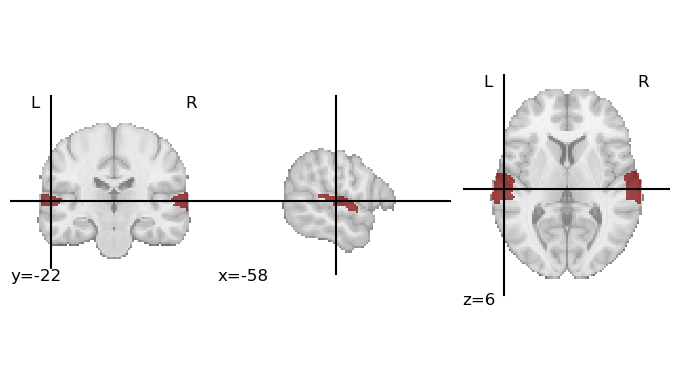

In [2]:
# Parcellation and Atlas References:
    # https://dartbrains.org/content/Parcellations.html#summary-of-differences-between-parcellations
    # https://nipy.org/nibabel/nibabel_images.html
    # https://nilearn.github.io/dev/auto_examples/03_connectivity/plot_signal_extraction.html
    # https://nilearn.github.io/dev/modules/generated/nilearn.regions.Parcellations.html
    # https://dartbrains.org/content/Parcellations.html#nilearn
    # https://carpentries-incubator.github.io/SDC-BIDS-fMRI/aio/index.html

def create_mask(dir='../resources/rois/', n_rois=200, yeo_networks=17, resolution_mm=1):
    """
    Create a brain mask using the Schaefer atlas or a provided directory.
    
    Parameters:
    dir (str): Directory to fetch or load atlas data from.
    n_rois (int): Number of regions of interest.
    yeo_networks (int): Number of Yeo networks.
    resolution_mm (int): Resolution in millimeters.

    Returns:
    tuple: NiftiLabelsMasker object, atlas image, and region labels.
    """
    if dir == '../resources/rois/':
        parcel_dir = dir
        schaefer = datasets.fetch_atlas_schaefer_2018(n_rois, yeo_networks, resolution_mm, data_dir=parcel_dir)
        atlas_schaefer = schaefer['maps']
        atlas = connected_label_regions(atlas_schaefer)
    else:
        atlas = dir

    masker = input_data.NiftiLabelsMasker(labels_img=atlas, standardize=True)
    atlas_img = nimg.load_img(atlas)
    region_labels = np.unique(atlas_img.get_fdata())
    region_labels = np.setdiff1d(region_labels, [0])  # Remove the background label (0)

    return masker, atlas, region_labels

def view_labels(atlas, roi='a == 1'):
    """
    View the labels of the atlas for a specified region of interest (ROI).
    
    Parameters:
    atlas (Nifti1Image): Atlas image.
    roi (str): Mathematical expression to specify the ROI.

    """
    roi_mask = nimg.math_img(roi, a=atlas)
    nplot.plot_roi(roi_mask, cmap='jet')

fine_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_fine_208parcels.nii.gz"
# course_ICP = "/project/3022057.01/resources/rois/ICPAtlas_v4_coarse_79parcels.nii.gz"  # Uncomment this, comment above, and change below for course ICP
mask, atlas, region_labels = create_mask(fine_ICP)
print("Number of Labels in Mask: ", len(region_labels))
view_labels(atlas)

### DONT RUN (Unless Subjects Are Not Parcellated) Load and Parcellate Subjects (REVIST INCOMPLETE)

In [ ]:
def load(n=0, folder1=0, folder2=-1):
    """
    Load data for a specified number of subjects and fMRI tasks.

    Parameters:
    n (int): Number of subjects to load (default is 0).
    folder1 (int): Index of the first fMRI task folder (default is 0).
    folder2 (int): Index of the second fMRI task folder, if any (default is -1).

    Returns:
    list: A list of tuples containing paths to the subject data files.
    """
    # Min and max number of subjects
    if n < 0:
        n = 0
    elif n > 1113:
        n = 1113

    # Define the directory where the data is stored
    base_directory = "/project_cephfs/3022017.01/S1200"
    subdirectory = "MNINonLinear/Results"
    
    # Define the list of folders for rfMRI and tfMRI
    folders = [
        "rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL",
        "tfMRI_EMOTION_LR", "tfMRI_EMOTION_RL", "tfMRI_GAMBLING_LR", "tfMRI_GAMBLING_RL",
        "tfMRI_LANGUAGE_LR", "tfMRI_LANGUAGE_RL", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_RL",
        "tfMRI_RELATIONAL_LR", "tfMRI_RELATIONAL_RL", "tfMRI_SOCIAL_LR", "tfMRI_SOCIAL_RL",
        "tfMRI_WM_LR", "tfMRI_WM_RL"
    ]
    
    # Randomly select n subjects without repetition
    selected_subjects = set()
    subjects = os.listdir(base_directory)
    while len(selected_subjects) < n:
        subject = random.choice(subjects)
        subject_data1 = os.path.join(base_directory, subject, subdirectory, folders[folder1], folders[folder1] + ".nii.gz")

        # Check if the file exists before adding the subject
        if os.path.exists(subject_data1):
            if folder2 >= 0:
                subject_data2 = os.path.join(base_directory, subject, subdirectory, folders[folder2], folders[folder2] + ".nii.gz")
                # Check if the second file exists before adding it
                if os.path.exists(subject_data2):
                    selected_subjects.add((subject_data1, subject_data2))
            else:
                selected_subjects.add((subject_data1,))

    return [list(sub) for sub in selected_subjects]

def parcellate(sub_data, masker, region_labels, verbose=False):
    """
    Parcellate fMRI data into regions of interest.

    Parameters:
    sub_data (Nifti1Image): The fMRI data to be parcellated.
    masker: The masker object used for parcellation.
    region_labels (list): List of region labels for the parcellation.
    verbose (bool): If True, print additional information (default is False).

    Returns:
    np.ndarray: The parcellated fMRI data.
    """
    # Create parcellated data
    parcellated = masker.fit_transform(sub_data)
    num_labels = len(region_labels)
    
    # Number of timepoints
    num_timepoints = sub_data.shape[3]
    # Create an array of zeros that has the correct size
    final_signal = np.zeros((num_timepoints, num_labels))

    # Get regions that are kept
    regions_kept = np.array(masker.labels_, dtype='int')

    # Fill columns matching labels with signal values
    final_signal[:, regions_kept-1] = parcellated
    if verbose:
        print("Number of atlas labels: ", num_labels)
        print("Number of parcellated labels: ", len(masker.labels_))
        print("Missing labels: ", set(region_labels) - set(np.unique(masker.labels_)))
    return final_signal

def parcellate_all(allsubs, mask, region_labels, save=False, verbose=False, location=''):
    """
    Parcellate data for all subjects and tasks, and optionally save the results.

    Parameters:
    allsubs (list): List of subject data paths.
    mask: The masker object used for parcellation.
    region_labels (list): List of region labels for the parcellation.
    save (bool): If True, save the parcellated data (default is False).
    verbose (bool): If True, print additional information (default is False).
    location (str): The directory location to save the parcellated data (default is '').

    Returns:
    list: List of parcellated data arrays for all subjects and tasks.
    """
    main_output_directory = os.path.normpath(r"/project/3022057.01/")

    alldata = []
    for sub in allsubs:
        for task in sub:
            if verbose:
                print(task)
            sub_data = nimg.load_img(task)
            parcellated = parcellate(sub_data, mask, region_labels, verbose=verbose)
            alldata.append(parcellated)
            if save:
                subdir = task[task.find("S1200") + len("S1200"):].split("/")[1]
                taskdir = task[task.find("Results") + len("Results"):].split("/")[1]
                sub_output_directory = os.path.join(main_output_directory, location, subdir)
                os.makedirs(sub_output_directory, exist_ok=True)
                output_filename = os.path.join(sub_output_directory, f"{taskdir}_parcellated.npy")
                if verbose:
                    print(output_filename)
                np.save(output_filename, parcellated)
    return alldata

n = 200
folder1 = 8
folder2 = 16

allsubs = load(n, folder1, folder2)
print(allsubs)
alldata = parcellate_all(allsubs, mask, region_labels, save=True, verbose=True, location="icp_parcellated_subs")

### Load and or Simulate Data (REVIST INCOMPLETE)

TODO Time Series Checks and Paths Hardcoded

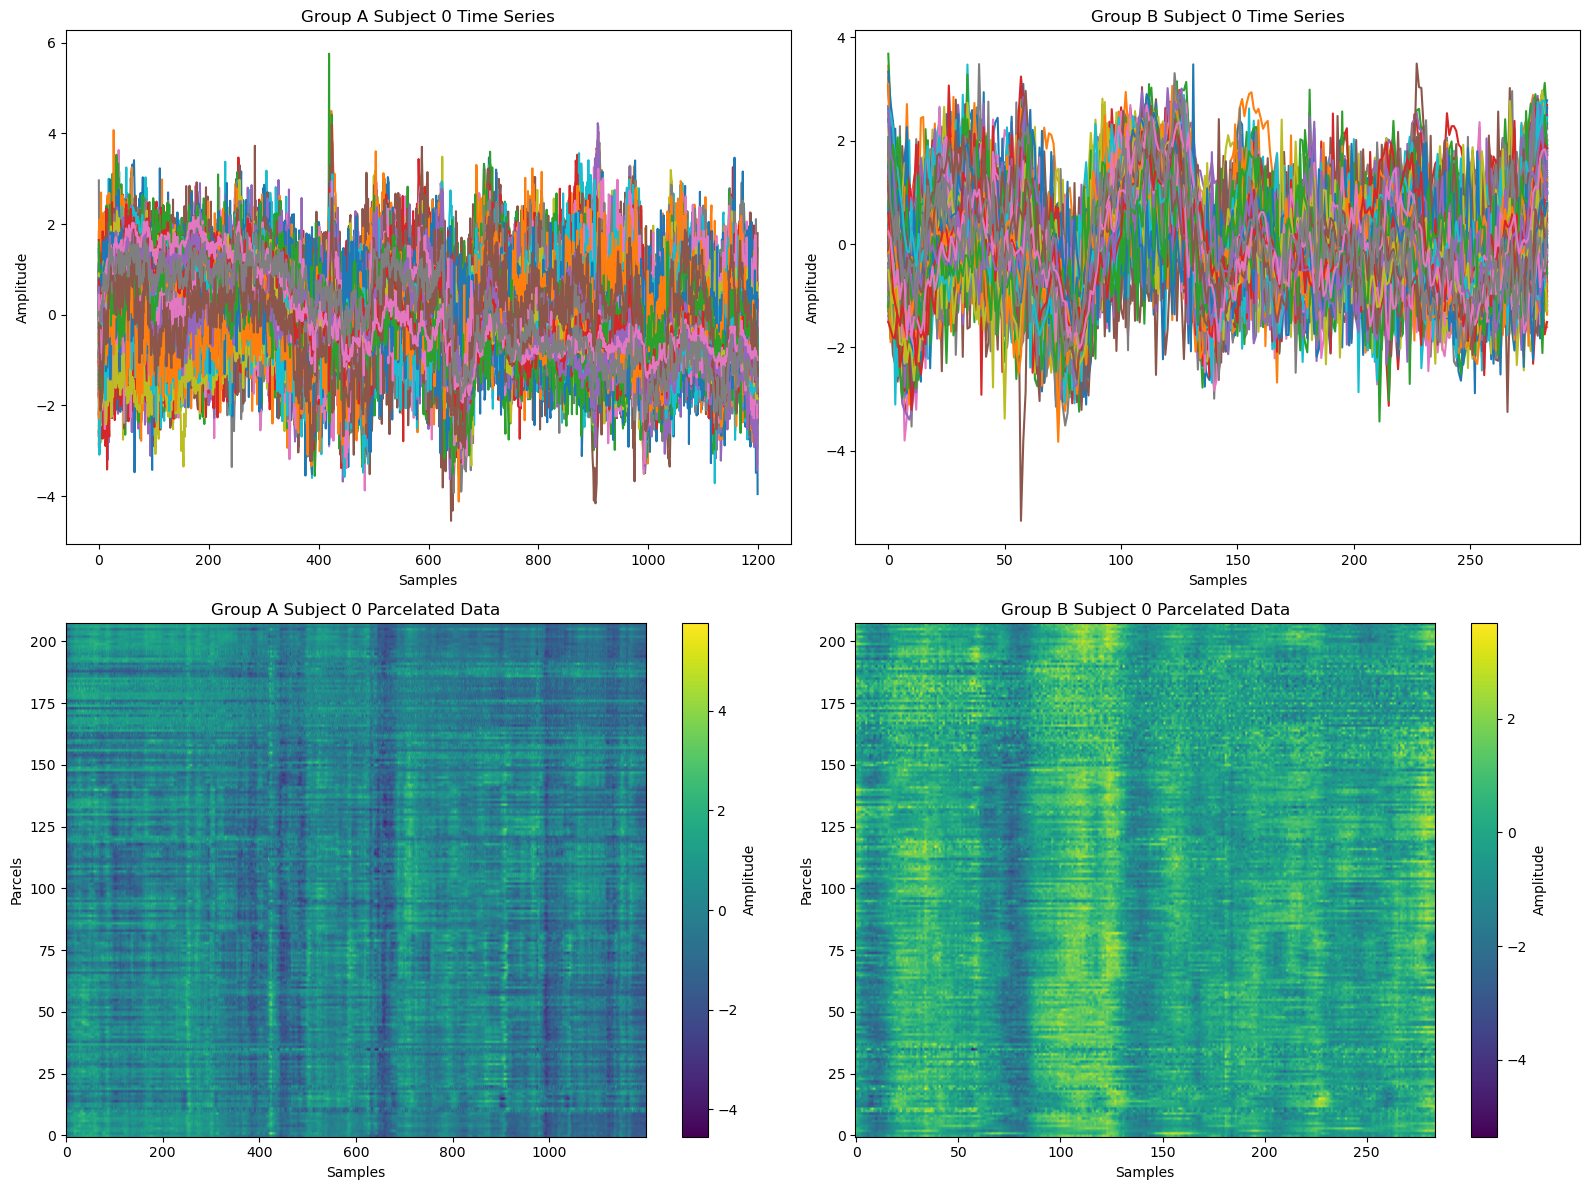

In [3]:
def create_signal(samples, parcels, sig_freqA=0.03, sig_freqB=0.05, spatial_ratio=0.1, signal_type="saw", visualize=False):
    """
    Create and add signal to a random subset of parcels.

    Parameters:
    samples (int): Number of samples.
    parcels (int): Number of parcels.
    sig_freqA (float): Frequency of the signal for group A.
    sig_freqB (float): Frequency of the signal for group B.
    spatial_ratio (float): Ratio of parcels to add the signal.
    signal_type (str): Type of the signal, 'saw' or 'sin'.
    visualize (bool): Whether to visualize the signals and heatmaps.

    Returns:
    tuple: groupA_signal, groupB_signal, groupA_parcels, groupB_parcels
    """
    
    num_parcels_with_signal = int(spatial_ratio * parcels)
    groupA_parcels = np.random.choice(parcels, size=num_parcels_with_signal, replace=False)
    groupB_parcels = np.random.choice(np.setdiff1d(np.arange(parcels), groupA_parcels), size=num_parcels_with_signal, replace=False)

    x = np.linspace(0, samples, num=samples)
    if signal_type == "sin":
        groupA_signal = np.sin(sig_freqA * x)
        groupB_signal = sawtooth(sig_freqB * x)
    else:
        groupA_signal = sawtooth(sig_freqA * x)
        groupB_signal = np.sin(sig_freqB * x)

    groupA_signal = (groupA_signal - np.mean(groupA_signal)) / np.std(groupA_signal)
    groupB_signal = (groupB_signal - np.mean(groupB_signal)) / np.std(groupB_signal)

    parcelsA = np.zeros((samples, parcels))
    parcelsB = np.zeros((samples, parcels))

    parcelsA[:, groupA_parcels] += np.reshape(groupA_signal, (-1, 1))
    parcelsB[:, groupB_parcels] += np.reshape(groupB_signal, (-1, 1))

    if visualize:
        plt.figure(figsize=(12, 12))
        plt.subplot(3, 1, 1)
        plt.imshow(parcelsA.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Generated Group A fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')
        
        plt.subplot(3, 1, 2)
        plt.imshow(parcelsB.T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Amplitude')
        plt.title('Heatmap of Generated Group B fMRI Matrix')
        plt.xlabel('Samples')
        plt.ylabel('Parcels')

        plt.subplot(3, 1, 3)
        plt.plot(groupA_signal, label="Group A Signal")
        plt.plot(groupB_signal, label="Group B Signal")
        plt.title('Signal in Selected Parcels')
        plt.legend()
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

    return groupA_signal, groupB_signal, groupA_parcels, groupB_parcels

def simulate_data(allsubs_data, sig_freqA=0.03, sig_freqB=0.5, spatial_ratio=0.01, sub_ratio=0.5, original_level=0.5, simulateA=True, simulateB=True):
    """
    Simulate data by adding signals to a subset of subjects.

    Parameters:
    allsubs_data (numpy.ndarray): Array of all subjects' data.
    sig_freqA (float): Frequency of the signal for group A.
    sig_freqB (float): Frequency of the signal for group B.
    spatial_ratio (float): Ratio of parcels to add the signal.
    sub_ratio (float): Ratio of subjects to add the signal.
    original_level (float): Weight of the original signal.
    simulateA (bool): Whether to simulate data for group A.
    simulateB (bool): Whether to simulate data for group B.

    Returns:
    tuple: groupA_data, groupB_data, groupA_parcels, groupB_parcels
    """
    
    samples = allsubs_data[0].shape[0]
    parcels = allsubs_data[0].shape[1]
    groupA_signal, groupB_signal, groupA_parcels, groupB_parcels = create_signal(samples, parcels, sig_freqA=sig_freqA, sig_freqB=sig_freqB, spatial_ratio=spatial_ratio, signal_type="saw", visualize=True)

    nsubjects = len(allsubs_data)
    nsubjects_semi_simulated = int(nsubjects * sub_ratio)

    selected_subjects = np.random.choice(nsubjects, size=nsubjects_semi_simulated, replace=False)
    unselected_subjects = np.setdiff1d(np.arange(nsubjects), selected_subjects)

    groupA_data = allsubs_data[selected_subjects, :, :].copy()
    groupB_data = allsubs_data[unselected_subjects, :, :].copy()
    
    if simulateA:
        for i, subject in enumerate(groupA_data):
            for parcel in groupA_parcels:
                subjectA_signal = (subject[:, parcel] - np.mean(subject[:, parcel])) / np.std(subject[:, parcel])
                groupA_data[i, :, parcel] = np.sqrt(original_level) * subjectA_signal + np.sqrt(1 - original_level) * groupA_signal

    if simulateB:
        for i, subject in enumerate(groupB_data):
            for parcel in groupB_parcels:
                subjectB_signal = (subject[:, parcel] - np.mean(subject[:, parcel])) / np.std(subject[:, parcel])
                groupB_data[i, :, parcel] = np.sqrt(original_level) * subjectB_signal + np.sqrt(1 - original_level) * groupB_signal

    return groupA_data, groupB_data, groupA_parcels, groupB_parcels

def visualize_semi_simulated_subject(groupA_data, groupB_data):
    """
    Visualize the semi-simulated subjects' data.

    Parameters:
    groupA_data (numpy.ndarray): Simulated data for group A.
    groupB_data (numpy.ndarray): Simulated data for group B.
    """
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    axes[0, 0].plot(groupA_data[0, :, :])
    axes[0, 0].set_title('Group A Subject 0 Time Series')
    axes[0, 0].set_xlabel('Samples')
    axes[0, 0].set_ylabel('Amplitude')

    axes[0, 1].plot(groupB_data[0, :, :])
    axes[0, 1].set_title('Group B Subject 0 Time Series')
    axes[0, 1].set_xlabel('Samples')
    axes[0, 1].set_ylabel('Amplitude')

    img = axes[1, 0].imshow(groupA_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 0])
    cbar.set_label('Amplitude')
    axes[1, 0].set_title('Group A Subject 0 Parcelated Data')
    axes[1, 0].set_xlabel('Samples')
    axes[1, 0].set_ylabel('Parcels')
    
    img = axes[1, 1].imshow(groupB_data[0, :, :].T, aspect='auto', cmap='viridis', origin='lower')
    cbar = plt.colorbar(img, ax=axes[1, 1])
    cbar.set_label('Amplitude')
    axes[1, 1].set_title('Group B Subject 0 Parcelated Data')
    axes[1, 1].set_xlabel('Samples')
    axes[1, 1].set_ylabel('Parcels')

    plt.tight_layout()
    plt.show()



subjects_path = r'/project/3022057.01/icp_parcellated_subs'
groupA_data = []
groupB_data = []
groupA_type = "REST"
groupB_type = "MOTOR"
simulate = False

if simulate:
    allsubs_data = []
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
            if groupA_type in file:
                sub_data = np.load(os.path.join(subdir,file))
                if sub_data.shape[0] == 1200:
                    allsubs_data.append(sub_data)
    allsubs_data = np.array(allsubs_data)
    groupA_data, groupB_data, groupA_parcels, groupB_parcels = simulate_data(allsubs_data, sig_freqA=.05,sig_freqB=.027, spatial_ratio=.01, sub_ratio=.5, original_level=.1, simulateA=True, simulateB=True)
else:
    for subdir, dirs, files in os.walk(subjects_path):
        for file in files:
            if groupA_type in file:
                sub_data = np.load(os.path.join(subdir,file))
                if sub_data.shape[0] == 1200:
                    groupA_data.append(sub_data)
            elif (groupB_type in file):
                groupB_data.append(np.load(os.path.join(subdir,file)))

groupA_data = np.array(groupA_data)
groupB_data = np.array(groupB_data)

visualize_semi_simulated_subject(groupA_data, groupB_data)

### Standardize and Demean Subjects (REVIST INCOMPLETE)

TODO Need to decide whether to demean on the subject level, group level, or across spatial dimensions. Will change for application/branch of pipeline

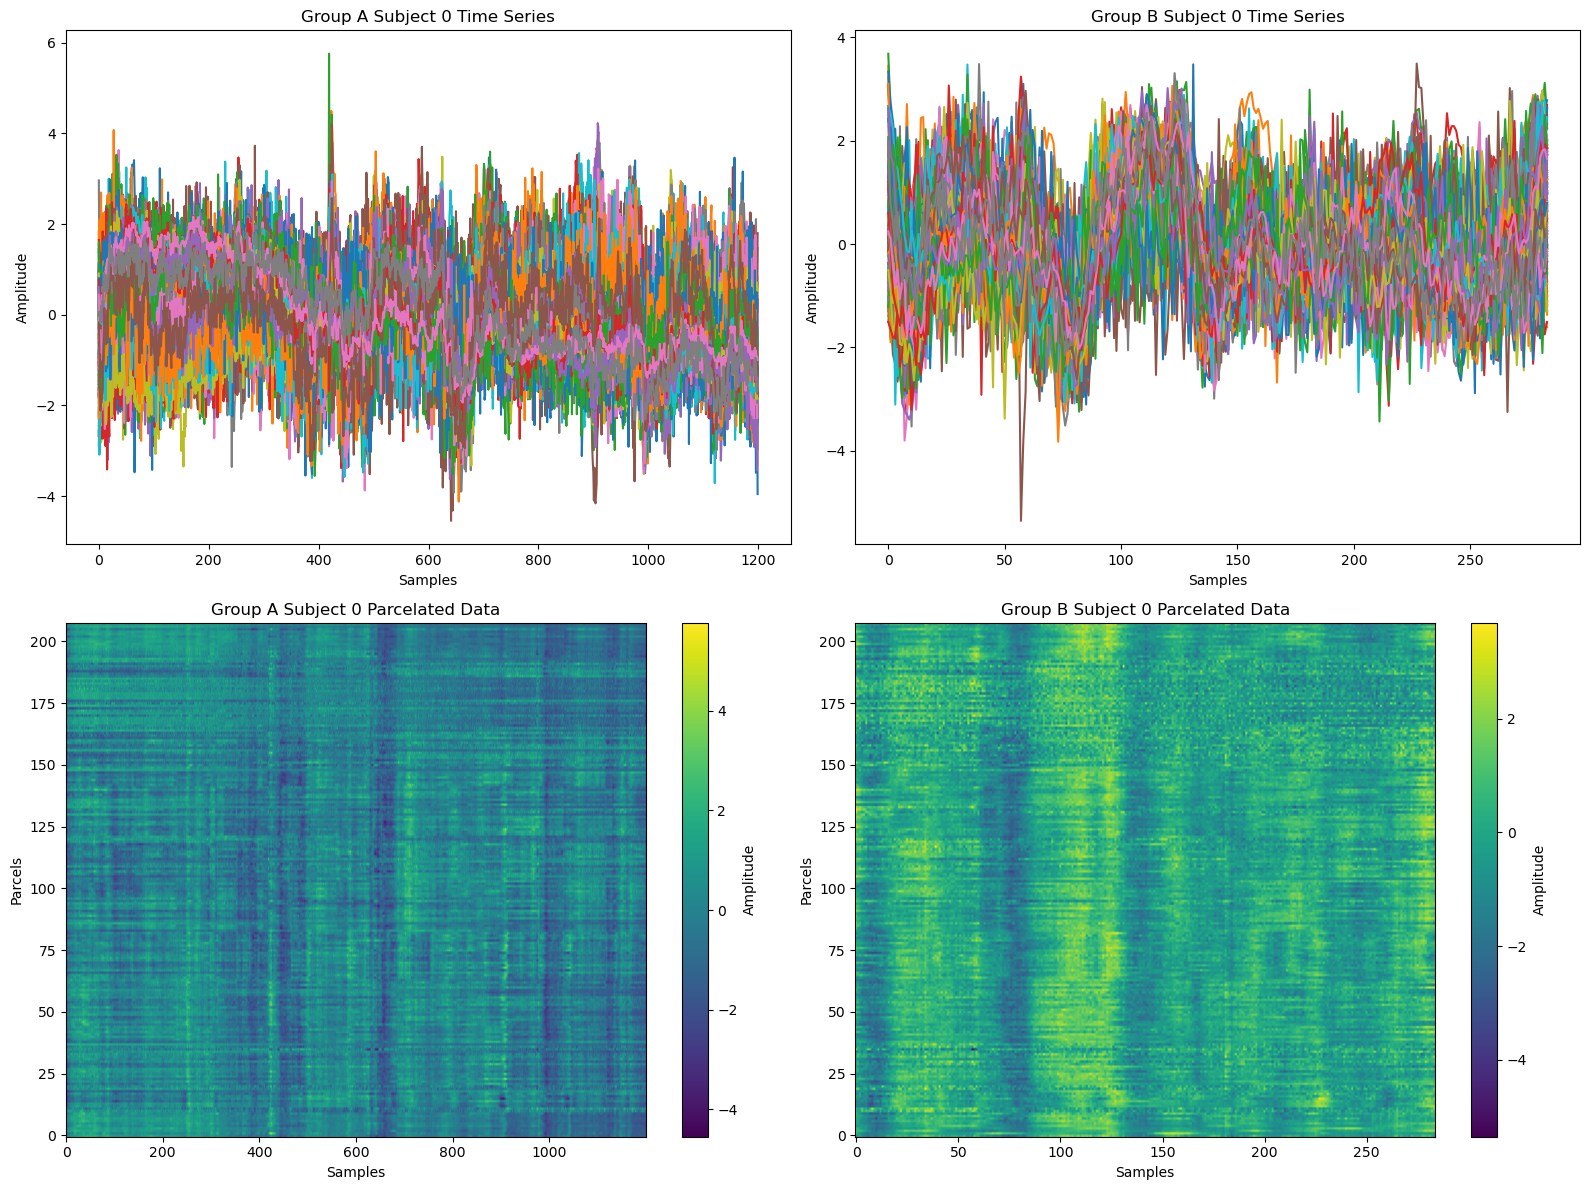

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def standardize_demean_individual(group):
    n_subjects, n_timepoints, n_features = group.shape
    preprocessed_group = np.zeros_like(group)

    for i in range(n_subjects):
        subject = group[i]
        
        # Handle NaNs by imputing with the mean of the column
        imputer = SimpleImputer(strategy='mean')
        subject_imputed = imputer.fit_transform(subject)
        
        # Standardize (demean and scale to unit variance) each subject individually
        scaler = StandardScaler()
        standardized_subject = scaler.fit_transform(subject_imputed)
        
        preprocessed_group[i] = standardized_subject

    return preprocessed_group

# Assuming groupA_data and groupB_data are defined
preprocessed_GroupA = standardize_demean_individual(groupA_data)
preprocessed_GroupB = standardize_demean_individual(groupB_data)
# Assuming visualize_semi_simulated_subject is defined
visualize_semi_simulated_subject(preprocessed_GroupA, preprocessed_GroupB)

### Create Covariance Matrices (REVIST INCOMPLETE)

TODO Partial Covariances?

In [5]:
# https://pyriemann.readthedocs.io/en/latest/auto_examples/signal/plot_covariance_estimation.html
cov_est = Covariances(estimator='lwf')

# Compute the covariance matrices for preprocessed_GroupA and preprocessed_GroupB
groupA_covs = cov_est.transform(np.transpose(preprocessed_GroupA, (0, 2, 1)))
groupB_covs = cov_est.transform(np.transpose(preprocessed_GroupB, (0, 2, 1)))

### FKT Methods

In [6]:
def SPADE_Cost(preprocessed_GroupA,preprocessed_GroupB,filters):
    groupA = preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2])
    groupB = preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2])
    return np.abs(np.var(groupA@filters, axis=0) - np.var(groupB@filters, axis=0))

def FKT(groupA_cov_matrices, groupB_cov_matrices, preprocessed_GroupA, preprocessed_GroupB, mean="riemann", average=True, visualize=True, gamma=0.0):
    if average:
        groupA_cov = mean_covariance(groupA_cov_matrices, metric=mean)
        groupB_cov = mean_covariance(groupB_cov_matrices, metric=mean)    
        eigs, filters = eigh(groupA_cov, groupA_cov + groupB_cov + gamma*np.identity(groupB_cov.shape[0]),eigvals_only=False)
    else:
        eigs, filters = eigh(groupA_cov_matrices, groupA_cov_matrices + groupB_cov_matrices,eigvals_only=False)
  
    fkt_riem_eigs = np.abs(np.log(eigs/(1-eigs)))**2
    SPADE_eigs = SPADE_Cost(preprocessed_GroupA,preprocessed_GroupB,filters)

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].scatter(range(0,fkt_riem_eigs.shape[0]),fkt_riem_eigs)
        axs[0].set_title('Scree Plot of FKT Filters')
        axs[0].set_xlabel('Eig Value Rank')
        axs[0].set_ylabel('Eig Value')

        axs[1].scatter(range(0,filters.shape[1]),SPADE_eigs)
        axs[1].set_title('Variance + Discrimination Score of Filters')
        axs[1].set_xlabel('Filter Rank')
        axs[1].set_ylabel('Variance + Discrimination Score of Filters')

        plt.tight_layout()
        plt.show()
        
    return SPADE_eigs, filters, fkt_riem_eigs

def tangent_CSP(group1_covs, group2_covs, preprocessed_GroupA, preprocessed_GroupB, mean="riemann", average=True, visualize=False, k=1):    
    all_covs = np.concatenate((group1_covs, group2_covs))
    Frechet_Mean = mean_covariance(all_covs, metric='riemann')
    tangent_projected_1 = tangent_space(group1_covs, Frechet_Mean, metric="riemann")
    tangent_projected_2 = tangent_space(group2_covs, Frechet_Mean, metric="riemann")

    # Initialize the Covariances estimator
    cov_estimator = Covariances(estimator='lwf')
    tangent_projected_mean = np.mean(np.concatenate((tangent_projected_1, tangent_projected_2)),axis=0,keepdims=True)  
    
    tangent_1_mean = np.mean(tangent_projected_1,axis=0,keepdims=True) - tangent_projected_mean
    tangent_2_mean = np.mean(tangent_projected_2,axis=0,keepdims=True) - tangent_projected_mean
    tangent_between_scatter = tangent_1_mean.T@tangent_1_mean + tangent_2_mean.T@tangent_2_mean
    
    # Estimate the covariance matrices
    cov_tangent_projected_1 = cov_estimator.transform(np.transpose(tangent_projected_1[np.newaxis,:,:],(0,2,1)))[0]
    cov_tangent_projected_2 = cov_estimator.transform(np.transpose(tangent_projected_2[np.newaxis,:,:],(0,2,1)))[0]
    

    # Convert to PyTorch tensors and move to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(("cuda" if torch.cuda.is_available() else "cpu"))
    cov_tangent_projected_1 = torch.tensor(cov_tangent_projected_1, dtype=torch.float32, device=device)
    cov_tangent_projected_2 = torch.tensor(cov_tangent_projected_2, dtype=torch.float32, device=device) 
    tangent_between_scatter = torch.tensor(tangent_between_scatter, dtype=torch.float32, device=device)
    
    # For filtersA
    _, eigvecs = torch.lobpcg(tangent_between_scatter, B=cov_tangent_projected_1 + cov_tangent_projected_2 + 0.0 * torch.eye(cov_tangent_projected_1.shape[0], device=cov_tangent_projected_1.device), k=k, largest=True)
    eigvecs_array = eigvecs.clone().cpu().numpy()
    filters = untangent_space(eigvecs_array.T, Frechet_Mean)
    SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent = FKT(filters[0,:,:], Frechet_Mean, preprocessed_GroupA, preprocessed_GroupB, mean=mean, average=False, visualize=visualize, gamma=0.0)

    return SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent

### Create Null Distribution via Permutation Testing

In [7]:
from concurrent.futures import ProcessPoolExecutor
def single_run(data, n_classA, preprocessed_GroupA, preprocessed_GroupB, filters_func):
    # Shuffle the combined data locally
    np.random.shuffle(data)
    new_classA = data[:n_classA]
    new_classB = data[n_classA:]
    
    # Calculate filters using the permuted data
    var_discrim_distances, _, riem_distances = filters_func(new_classA, new_classB, preprocessed_GroupA, preprocessed_GroupB, mean="riemann", average=True, visualize=False)
    
    return riem_distances, var_discrim_distances

def simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, filters_func, n_simulations=10):
    n_classA = groupA_covs.shape[0]
    combined_data = np.vstack([groupA_covs, groupB_covs])

    riem_distances = []
    var_discrim_distances = []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(single_run, combined_data.copy(), n_classA, preprocessed_GroupA, preprocessed_GroupB, filters_func) for _ in range(n_simulations)]
        for future in futures:
            perm_result, alt_result = future.result()
            riem_distances.extend(perm_result)
            var_discrim_distances.extend(alt_result)
    
    # Visualize the results for permuted distances
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(riem_distances, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Riemannian Eigenvalues Under the Null Hypothesis')
    plt.xlabel('Riemannian Distance Approximation')
    plt.ylabel('Frequency')

    # Visualize the results for alternate distances
    plt.subplot(1, 2, 2)
    plt.hist(var_discrim_distances, bins=20, color='red', alpha=0.7)
    plt.title('Histogram of Variance Differences')
    plt.xlabel('Variance Difference')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return riem_distances, var_discrim_distances

def test_significance(null_distribution, test_statistics, alpha=0.05):
    """
    Calculate p-values for test statistics against a null distribution and apply Bonferroni correction.

    Parameters:
    - null_distribution (array-like): The distribution of values under the null hypothesis.
    - test_statistics (array-like): The statistics to test against the null distribution.
    - alpha (float): The significance level for the tests (default is 0.05).

    Returns:
    - p_values (np.array): The p-values for each test statistic.
    - significant_tests (np.array): Boolean array indicating which tests are significant.
    """
    # Calculate p-values
    p_values = np.array([np.mean(null_distribution >= ts) for ts in test_statistics])

    # Apply Bonferroni correction
    number_of_tests = len(test_statistics)
    bonferroni_alpha = alpha / number_of_tests

    # Determine which tests are significant
    significant_tests = np.where(p_values < bonferroni_alpha)[0]

    return p_values, significant_tests

### Run FKT and Generate Null Distributions

In [8]:
def FKT_proj(group,filters):
    # Method 1
    cov_est_scm = Covariances(estimator='scm')
    f_cov = cov_est_scm.transform(filters.T[np.newaxis,:,:])[0,:,:]
    S = group@filters@np.linalg.inv(f_cov)
    return S

def filter_PCA(S):
    pca = PCA(n_components='mle')  # automatic model selection
    principal_components = pca.fit_transform(S)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    print("Number of Principal Components: ", principal_components.shape[1])
    
    # Generate scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
    plt.grid()
    plt.show()
    
    return principal_components

def FKT_var_select(preprocessed_GroupA,preprocessed_GroupB, filters):
    groupA = preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2])
    groupB = preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2])
    var_explained = np.var(groupA@filters, axis=0) - np.var(groupB@filters, axis=0)
    a_filters = np.where(var_explained > 0)[0]
    b_filters = np.where(var_explained < 0)[0]
    
    reshaped_preprocessed_subjects = np.array(np.vstack((preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2]), preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2]))))
    reduced_filters = filter_PCA(FKT_proj(reshaped_preprocessed_subjects,filters))

    # FKT_proj_A = filter_PCA(FKT_proj(groupA,filters[:,a_filters]))
    # FKT_proj_B = filter_PCA(FKT_proj(groupB,filters[:,b_filters]))

    # groupA_reduced = FKT_proj(reshaped_preprocessed_subjects,FKT_proj(groupA.T,FKT_proj_A))
    # groupB_reduced = FKT_proj(reshaped_preprocessed_subjects,FKT_proj(groupB.T,FKT_proj_B))
    # reduced_filters = np.concatenate((groupA_reduced,groupB_reduced),axis=1)


    # Concatenate zeros for the sections that correspond to the other group
    # zero_padding_A = np.zeros((FKT_proj_B.shape[0],FKT_proj_A.shape[1]))
    # zero_padding_B = np.zeros((FKT_proj_A.shape[0],FKT_proj_B.shape[1]))
    # FKT_proj_A_padded = np.concatenate((FKT_proj_A, zero_padding_A), axis=0)
    # FKT_proj_B_padded = np.concatenate((zero_padding_B, FKT_proj_B), axis=0)
    # reduced_filters = np.concatenate((FKT_proj_A_padded,FKT_proj_B_padded),axis=1)

    return reduced_filters

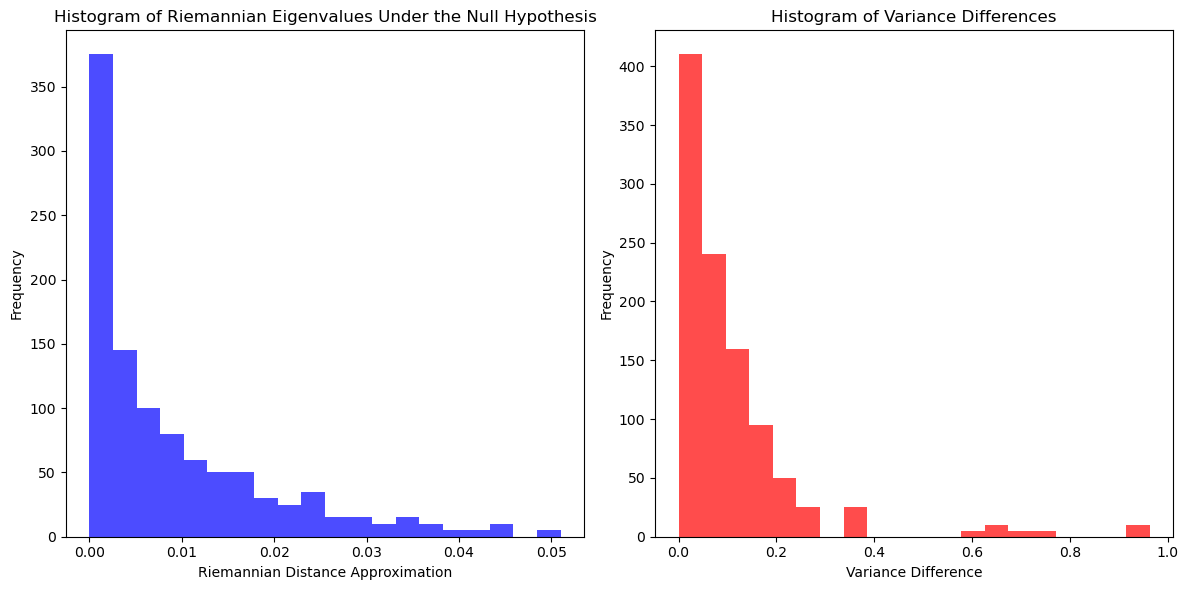

In [9]:
# Generate null distributions for normal FKT
riem_distances, var_discrim_distances = simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, FKT,n_simulations=5)

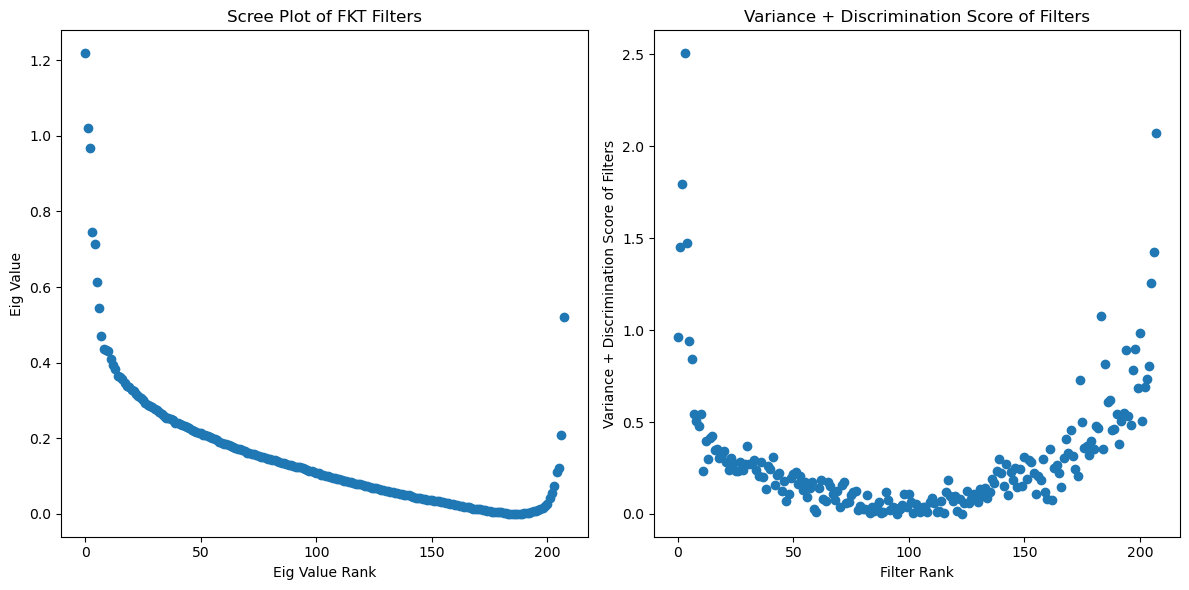

Significant tests for Riemannian distances: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 202 203 204 205 206 207]
Significant tests for variance differences: [  0   1   2   3   4 183 200 205 206 207]
Number of Principal Components:  143


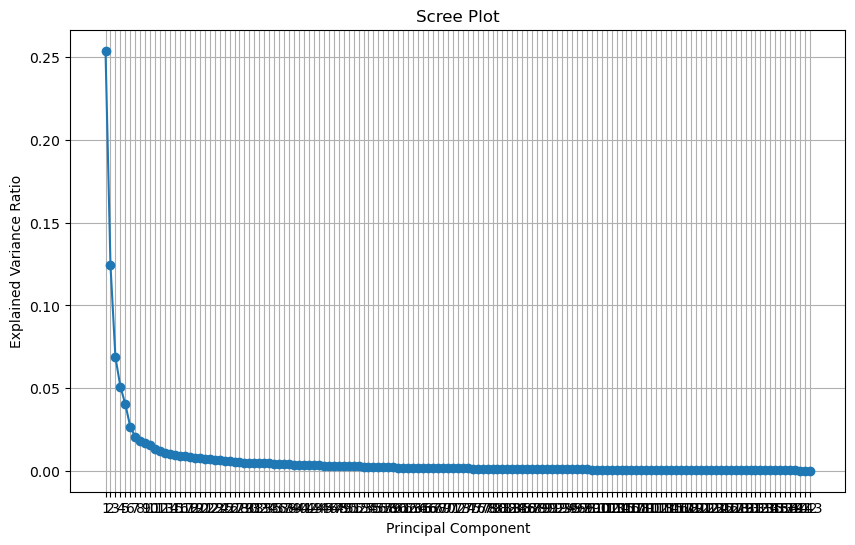

In [10]:
reshaped_preprocessed_subjects = np.array(np.vstack((preprocessed_GroupA.reshape(-1, preprocessed_GroupA.shape[2]), preprocessed_GroupB.reshape(-1, preprocessed_GroupB.shape[2]))))

SPADE_eigs, fkt_filters, fkt_riem_eigs = FKT(groupA_covs, groupB_covs,preprocessed_GroupA,preprocessed_GroupB, mean="riemann", average=True, visualize=True, gamma=0.0)

p_values_riem, significant_tests_riem = test_significance(riem_distances, fkt_riem_eigs)
p_values, significant_tests = test_significance(var_discrim_distances, SPADE_eigs)

print(f"Significant tests for Riemannian distances: {significant_tests_riem}")
print(f"Significant tests for variance differences: {significant_tests}")

if len(significant_tests_riem) > 0:
    top_filters_riem = FKT_var_select(preprocessed_GroupA,preprocessed_GroupB,fkt_filters[:,significant_tests_riem])

if len(significant_tests) > 0:
    top_filters = FKT_proj(reshaped_preprocessed_subjects,fkt_filters[:,significant_tests])

cuda


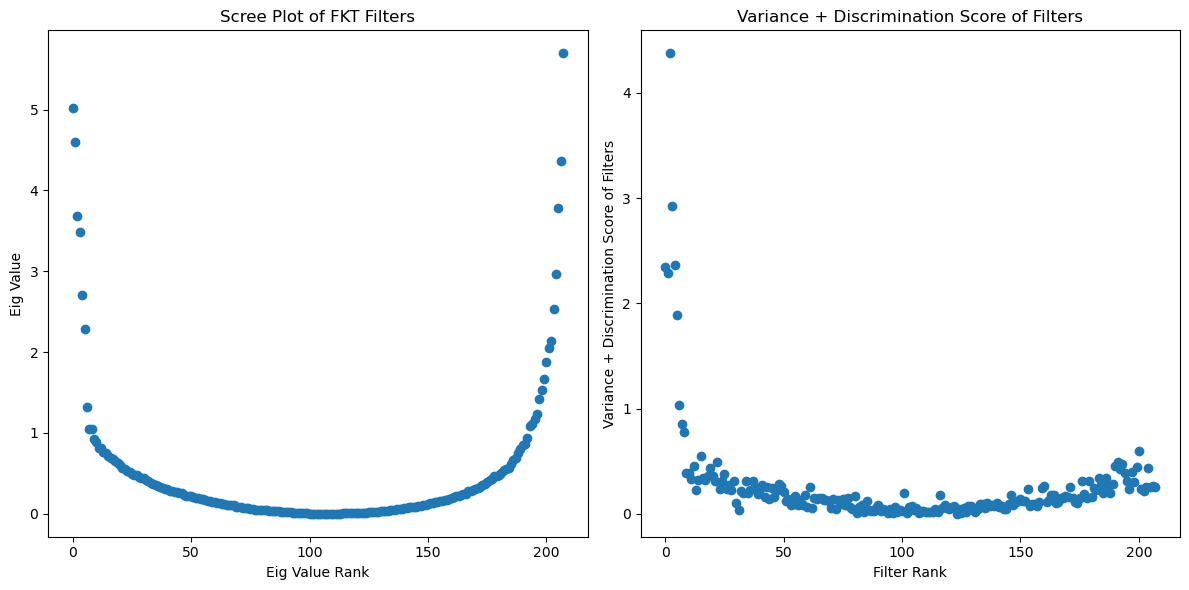

In [13]:
# # Generate null distributions for tangent FKT
# riem_distances_tangent, var_discrim_distances_tangent = simulate_FKT(preprocessed_GroupA, preprocessed_GroupB, groupA_covs, groupB_covs, tangent_CSP,n_simulations=1)

SPADE_eigs_tangent, fkt_filters_tangent, fkt_riem_eigs_tangent = tangent_CSP(groupA_covs,groupB_covs,preprocessed_GroupA, preprocessed_GroupB, mean="riemann", average=False, visualize=True, k=1)

# p_values_riem_tangent, significant_tests_riem_tangent = test_significance(riem_distances_tangent, fkt_riem_eigs_tangent)
# p_value_tangent, significant_tests_tangent = test_significance(var_discrim_distances_tangent, SPADE_eigs_tangent)

# print(f"Significant tests for Riemannian distances: {significant_tests_riem_tangent}")
# print(f"Significant tests for variance differences: {significant_tests_tangent}")

# top_filters_riem_tangent = fkt_filters_tangent[:,significant_tests_riem_tangent]
# top_filters_tangent = fkt_filters_tangent[:,significant_tests_tangent]

Number of Principal Components:  143


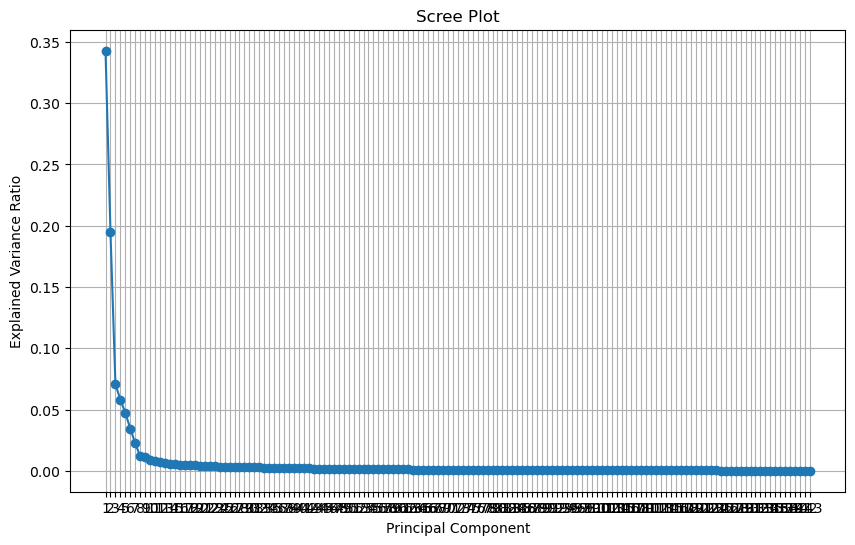

In [14]:
p_values_riem_tangent, significant_tests_riem_tangent = test_significance(riem_distances, fkt_riem_eigs_tangent)
top_filters_riem = FKT_var_select(preprocessed_GroupA,preprocessed_GroupB,fkt_filters_tangent[:,significant_tests_riem])
# p_value_tangent, significant_tests_tangent = test_significance(var_discrim_distances, SPADE_eigs_tangent)

# # print(f"Significant tests for Riemannian distances: {significant_tests_riem_tangent}")
# print(f"Significant tests for variance differences: {significant_tests_tangent}")

# # top_filters_riem_tangent = fkt_filters_tangent[:,significant_tests_riem_tangent]
# if len(significant_tests) > 0:
#     top_filters_tangent = FKT_proj(reshaped_preprocessed_subjects,fkt_filters[:,significant_tests])

### Generate Major Eigenspace

In [ ]:
(preprocessed_GroupA[:5].reshape(-1, preprocessed_GroupA.shape[2])).shape

In [ ]:
from scipy.linalg import svd

def bayesian_pca_evidence(eigenvalues, d, N):
    """
    Calculate the Bayesian evidence for each possible number of components.
    
    Parameters:
    eigenvalues (np.ndarray): Eigenvalues from PCA
    d (int): Dimensionality of the data (number of features)
    N (int): Number of data points
    
    Returns:
    np.ndarray: Evidence for each number of components
    """
    evidences = []
    for k in range(1, len(eigenvalues) + 1):
        alpha = np.mean(eigenvalues[k:]) / (d - k)
        evidence = -0.5 * N * (np.sum(np.log(alpha + eigenvalues[:k])) + (d - k) * np.log(alpha))
        evidences.append(evidence)
    return np.array(evidences)

def optimal_components_bayesian(eigenvalues, d, N):
    """
    Determine the optimal number of components using Bayesian model selection.
    
    Parameters:
    eigenvalues (np.ndarray): Eigenvalues from PCA
    d (int): Dimensionality of the data (number of features)
    N (int): Number of data points
    
    Returns:
    int: Optimal number of components
    """
    evidences = bayesian_pca_evidence(eigenvalues, d, N)
    return np.argmax(evidences) + 1

def incremental_pca_update(W, new_data, m):
    combined_data = np.vstack((W, new_data))
    U, S, Vt = svd(combined_data, full_matrices=False)
    return np.dot(np.diag(S[:m]), Vt[:m, :])

def MIGP(groupA, groupB, m, batch_size):

    # Initialize W with the first batch of subjects from group A
    initial_data = groupA[:batch_size].reshape(-1, groupA.shape[2])
    U, S, Vt = svd(initial_data, full_matrices=False)
    W = np.dot(np.diag(S[:m]), Vt[:m, :])
    
    # Process the remaining subjects in batches
    for i in range(batch_size, groupA.shape[0], batch_size):
        batch_end = min(i + batch_size, groupA.shape[0])
        new_data = groupA[i:batch_end].reshape(-1, groupA.shape[2])
        W = incremental_pca_update(W, new_data, m)
    
    # Process subjects from group B in batches
    for i in range(0, groupB.shape[0], batch_size):
        batch_end = min(i + batch_size, groupB.shape[0])
        new_data = groupB[i:batch_end].reshape(-1, groupB.shape[2])
        W = incremental_pca_update(W, new_data, m)
    
    return W


W = MIGP(preprocessed_GroupA, preprocessed_GroupB, 208,3)
# Perform PCA with all components
eigenvalues = svd(W, compute_uv=False)

# Determine the optimal number of components using Bayesian model selection

optimal_k = optimal_components_bayesian(eigenvalues, 208, W.shape[0])
print("Optimal number of Principal Components (Bayesian): ", optimal_k)

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, 'o-', markersize=5)
plt.axvline(x=optimal_k, color='r', linestyle='--', label='Optimal Components')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid()
plt.show()

### ICA

In [11]:
def IFA(data, fkt_filters):
    data_projected = FKT_proj(data.T,fkt_filters)
    ica = FastICA()
    IFA_components = ica.fit_transform(data_projected)
    return IFA_components

group_IFA_components = IFA(reshaped_preprocessed_subjects, top_filters)

/home/mrstats/zaisou/.conda/envs/IFA/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [ ]:
def visualize(all_filters):
     # Create a figure and axes for subplots
    fig, axes = plt.subplots(all_filters.shape[1], 1, figsize=(6, 4*all_filters.shape[1]))

    # Iterate over each axis of filters
    for i in range(all_filters.shape[1]):
        # Access the subplot using indexing
        if all_filters.shape[1] == 1:
            ax = axes
        else:
            ax = axes[i]

        # Calculate the outer product image for the current axis
        outer_product = all_filters[:, i:i+1]@ all_filters[:, i:i+1].T

        # Plot the outer product image on the corresponding subplot
        im = ax.imshow(outer_product, aspect='auto', cmap='viridis', origin='lower')
        ax.set_title(f"Outer Product for Axis {i}")
        fig.colorbar(im, ax=ax, label='Amplitude')

        plt.tight_layout()
    plt.show()

# visualize(group_IFA_components)

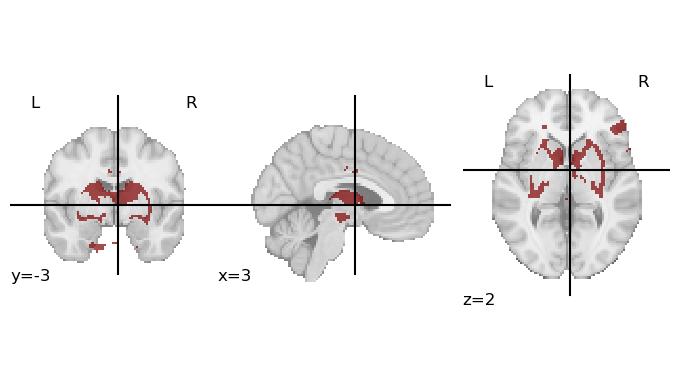

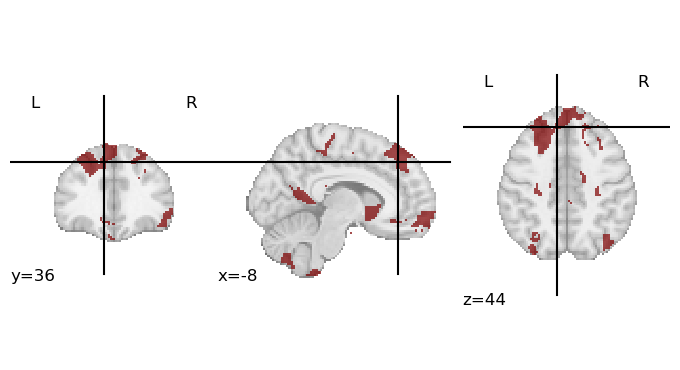

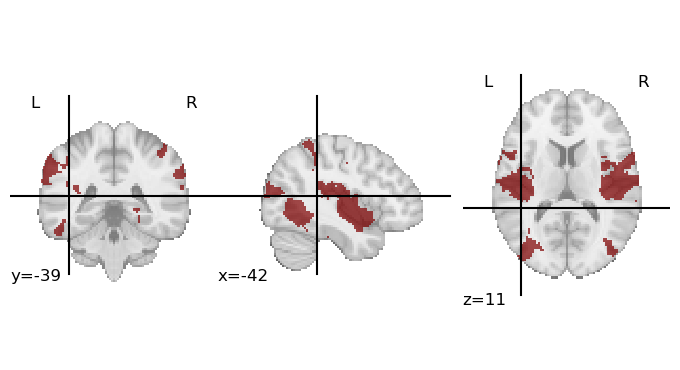

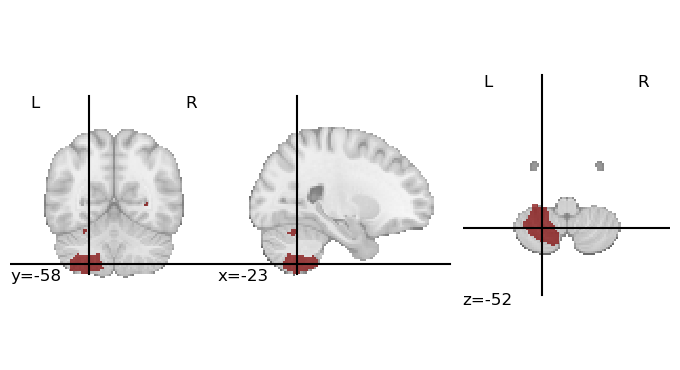

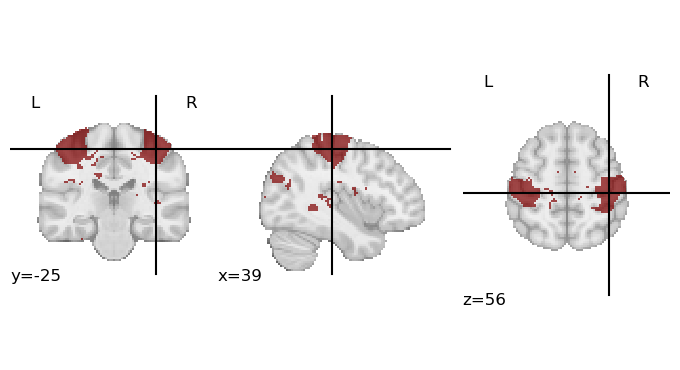

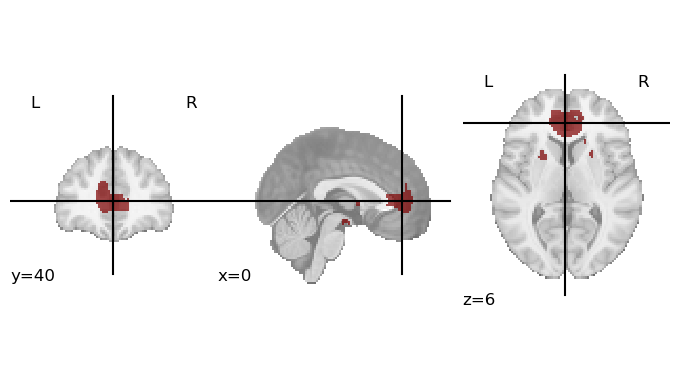

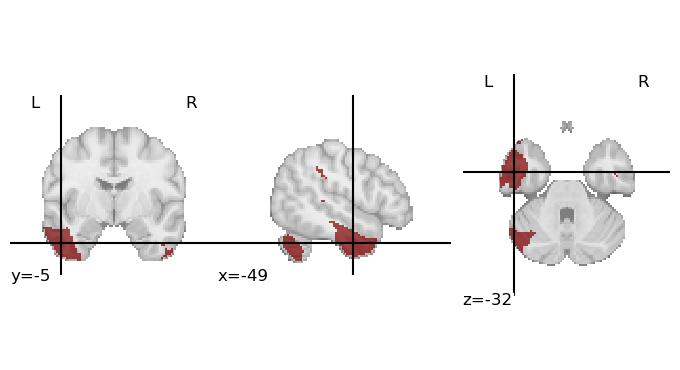

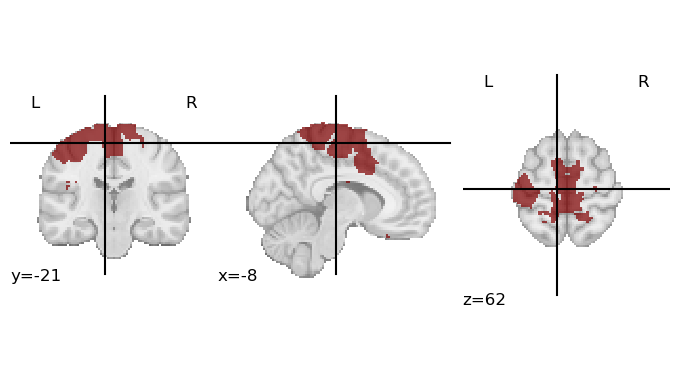

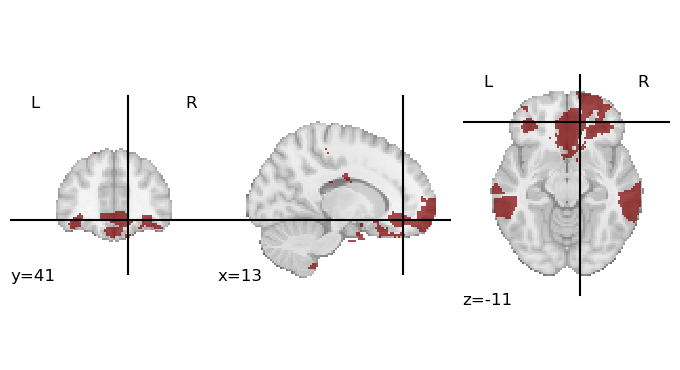

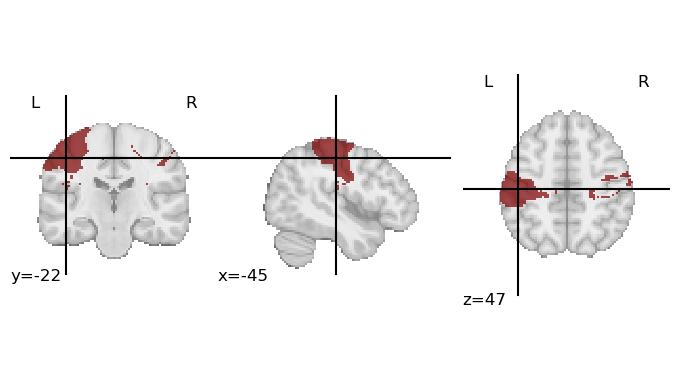

In [12]:
regions = []
brain_strings = []
masked_comps = []
for i in range(group_IFA_components.shape[1]):
    groupIFA_comp = group_IFA_components[:,i:i+1]
    std_groupIFA = (groupIFA_comp-np.mean(groupIFA_comp,keepdims=True,axis=0))/np.std(groupIFA_comp,axis=0)
    masked_comp = std_groupIFA*(np.abs(std_groupIFA)>2)
    masked_comps.append(masked_comp)
    array = np.where(np.abs(groupIFA_comp)>2)[0]+1
    regions.append(array)
    stringified_array = ' | '.join([f'(a == {num})' for num in array])
    final_string = f"(({stringified_array}))"
    brain_strings.append(final_string)
    view_labels(atlas, final_string)
masked_comps = np.array(masked_comps).T